In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import pysd
import math
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import pickle
import random
from sympy import symbols, limit, exp, factorial, oo
from scipy.optimize import differential_evolution
from sklearn.metrics import mean_absolute_error
import seaborn as sns


Loading the synthetic individual dataset

In [7]:
#load csv data
file_path = '../../Data/Synthetic/individual case 6.csv'
df = pd.read_csv(file_path, index_col=0)
df


,Effect,FINAL TIME,INITIAL TIME,Input noise,K,L1,L2,O,Perception,Reality,SAVEPER,seed,st dev 1,st dev 2,TIME STEP
Time,,,,,,,,,,,,,,,
0,0.213745,100.0,0.0,0.978053,1.0,10.0,30.0,3.0,0.000000,0.000000,1.0,9.0,0.25,0.25,1.0
1,-0.083424,NaN,NaN,0.923887,NaN,NaN,NaN,NaN,0.000000,0.092235,NaN,NaN,NaN,NaN,NaN
2,-0.041723,NaN,NaN,0.773635,NaN,NaN,NaN,NaN,0.000000,0.153698,NaN,NaN,NaN,NaN,NaN
3,-0.089725,NaN,NaN,0.536683,NaN,NaN,NaN,NaN,0.000000,0.158601,NaN,NaN,NaN,NaN,NaN
4,-0.037294,NaN,NaN,0.623704,NaN,NaN,NaN,NaN,0.002490,0.242882,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,1.205660,NaN,NaN,0.732233,NaN,NaN,NaN,NaN,1.009960,-0.127648,NaN,NaN,NaN,NaN,NaN
97,0.937967,NaN,NaN,0.866006,NaN,NaN,NaN,NaN,1.003680,-0.235346,NaN,NaN,NaN,NaN,NaN
98,1.014120,NaN,NaN,0.738497,NaN,NaN,NaN,NaN,0.994418,-0.270644,NaN,NaN,NaN,NaN,NaN


In [8]:
#create a dataframe with only two columns Reality and Effect 
values = df[['Reality', 'Effect']]
#rename the columns
values.columns = ['A', 'B']
values

,A,B
Time,,
0,0.000000,0.213745
1,0.092235,-0.083424
2,0.153698,-0.041723
3,0.158601,-0.089725
4,0.242882,-0.037294
...,...,...
96,-0.127648,1.205660
97,-0.235346,0.937967
98,-0.270644,1.014120


Asymmetric delay estimation

In [9]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

def Asy_delay6(values, d1, d2, o):
    df = values.copy()
    o = round(o)  # Ensure 'o' is an integer

    # Creating shifted columns based on the order 'o'
    for i in range(0, o + 1):
        column_name = f"B_est_{i}"
        df[column_name] = df["A"].astype(float)

    # Applying the delay logic
    for i in range(0, len(df["A"]) - 1):
        if df.loc[i, 'A'] < df.loc[i, f'B_est_{o}']:
            d = d2
        else:
            d = d1

        for j in range(1, o + 1):
            prev_column = f'B_est_{j-1}'
            current_column = f'B_est_{j}'
            df.loc[i + 1, current_column] = df.loc[i, current_column] + (df.loc[i, prev_column] - df.loc[i, current_column]) / (d / o)

    # Preparing the X (independent variable) and y (dependent variable) arrays
    X = df[f"B_est_{o}"].values
    y = df['B'].values

    # Note: We're NOT adding a constant term to X, as we don't want an intercept in the model

    # Fitting the model using statsmodels
    model = sm.OLS(y, X).fit()

    # Getting the model's predictions
    y_pred = model.predict(X)

    # Calculating the Mean Squared Error manually, since statsmodels doesn't provide it directly
    mse = np.mean((y - y_pred) ** 2)

    # Extracting the model's coefficients
    # Note: In a model without an intercept, there's just one coefficient for the predictor
    coefficients = model.params[0]
    # Mean Absolute Error
    mae = mean_absolute_error(y, y_pred)
    # R-squared
    r_squared = model.rsquared
    # AIC
    aic = model.aic
    # BIC
    bic = model.bic
    # Confidence Intervals for the coefficients
    ci = model.conf_int()

    return mse, coefficients, mae, r_squared, aic, bic, ci


In [10]:
def create_objective_function(values):
    def objective(params):
        delay1, delay2, order = map(int, params)  # Ensure parameters are integers
        mse, _, _, _, _, _, _= Asy_delay6(values, delay1, delay2, order)
        return mse
    return objective


In [11]:
# Assuming 'simulation_dict' contains your datasets
# 'answers' DataFrame is initialized to store the results

# Define bounds for delay1, delay2, and order
benchmark_bounds = [(1, 30), (1, 60), (1, 6)]

# Adjusted loop to use differential_evolution
# Create a customized objective function for the current dataset
custom_objective = create_objective_function(values)

# Perform the optimization using differential_evolution
#result = differential_evolution(custom_objective, benchmark_bounds, strategy='best1bin', maxiter=1000, popsize=15, tol=0.01, mutation=(0.5, 1), recombination=0.7)
result = differential_evolution(custom_objective, benchmark_bounds)

# Extract the optimal parameter values
optimal_delay1, optimal_delay2, optimal_order = result.x
#optimal_delay1, optimal_delay2, optimal_order = int(optimal_delay1), int(optimal_delay2), int(optimal_order)  # Convert to integers if necessary

# Recalculate mse and k using the optimal parameters
mse, k, mae, r2, aic, bic, ci = Asy_delay6(values, optimal_delay1, optimal_delay2, optimal_order)

print(f"Optimal delay1: {optimal_delay1}")
print(f"Optimal delay2: {optimal_delay2}")
print(f"Optimal order: {optimal_order}")
print(f"Optimal mse: {mse}")
print(f"Optimal k: {k}")
print(f"Optimal mae: {mae}")
print(f"Optimal r2: {r2}")
print(f"Optimal AIC: {aic}")
print(f"Optimal BIC: {bic}")
print(f"Optimal CI: {ci}")



Optimal delay1: 10.763105990904123
Optimal delay2: 31.40537686935017
Optimal order: 4.598311425962365
Optimal mse: 0.06123187894597199
Optimal k: 0.9531051436521167
Optimal mae: 0.19541653696012776
Optimal r2: 0.887171617355446
Optimal AIC: 6.523763652667185
Optimal BIC: 9.138884169508444
Optimal CI: [[0.88567073 1.02053956]]


In [12]:
# values = simulation_dict[i+1]
results = []

# Iterate over the parameter space
for order in range(1, 6):
    for delay1 in range(1, 30):
        for delay2 in range(1, 60):

            (mse, k, mae, r2, aic, bic, ci) = Asy_delay6(values, delay1,delay2, order)

            print('order:', order, 'delay1:', delay1, 'delay2:', delay2)
            results.append({'order': order, 'delay1': delay1, 'delay2':delay2, 'mse': mse, 'k': k, 'mae': mae, 'r2': r2, 'aic': aic, 'bic': bic, 'ci': ci})


df_results = pd.DataFrame(results)
df_sorted = df_results.sort_values(by='mse', ascending=True)
top_estimation = df_sorted.iloc[0]


order: 1 delay1: 1 delay2: 1
order: 1 delay1: 1 delay2: 2
order: 1 delay1: 1 delay2: 3
order: 1 delay1: 1 delay2: 4
order: 1 delay1: 1 delay2: 5
order: 1 delay1: 1 delay2: 6
order: 1 delay1: 1 delay2: 7
order: 1 delay1: 1 delay2: 8
order: 1 delay1: 1 delay2: 9
order: 1 delay1: 1 delay2: 10
order: 1 delay1: 1 delay2: 11
order: 1 delay1: 1 delay2: 12
order: 1 delay1: 1 delay2: 13
order: 1 delay1: 1 delay2: 14
order: 1 delay1: 1 delay2: 15
order: 1 delay1: 1 delay2: 16
order: 1 delay1: 1 delay2: 17
order: 1 delay1: 1 delay2: 18
order: 1 delay1: 1 delay2: 19
order: 1 delay1: 1 delay2: 20
order: 1 delay1: 1 delay2: 21
order: 1 delay1: 1 delay2: 22
order: 1 delay1: 1 delay2: 23
order: 1 delay1: 1 delay2: 24
order: 1 delay1: 1 delay2: 25
order: 1 delay1: 1 delay2: 26
order: 1 delay1: 1 delay2: 27
order: 1 delay1: 1 delay2: 28
order: 1 delay1: 1 delay2: 29
order: 1 delay1: 1 delay2: 30
order: 1 delay1: 1 delay2: 31
order: 1 delay1: 1 delay2: 32
order: 1 delay1: 1 delay2: 33
order: 1 delay1: 1 

In [13]:
top_estimation

order                                              4
delay1                                            10
delay2                                            31
mse                                         0.057664
k                                           0.964542
mae                                         0.187584
r2                                          0.893746
aic                                         0.460523
bic                                         3.075644
ci        [[0.8985608378806395, 1.0305241499143527]]
Name: 5694, dtype: object

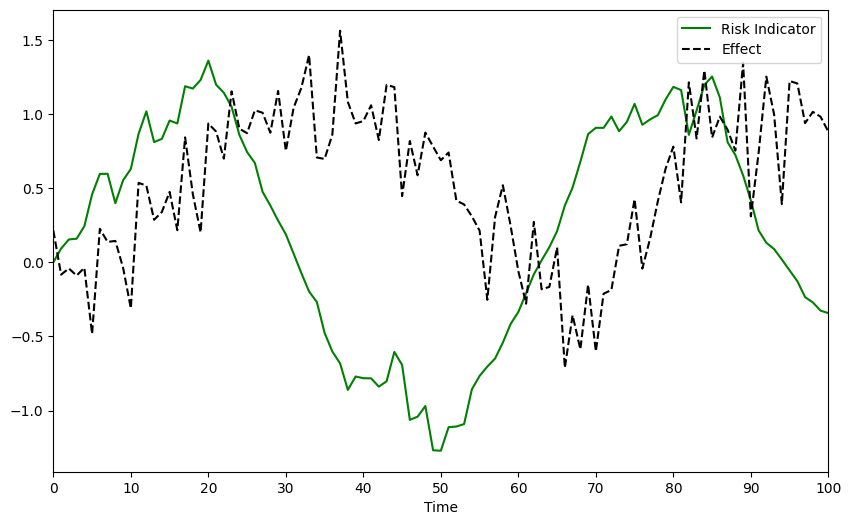

In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Make sure df['date'] is in datetime format
#df['Time'] = pd.to_datetime(df['Time'])

# Adjust figure size for better readability
plt.figure(figsize=(10, 6))

# Plot with 'date' on the x-axis
plt.plot (df['Reality'], label='Risk Indicator', color='green')
plt.plot (df['Effect'], label='Effect', color='black', linestyle='dashed')

# Add legend, title, and labels
plt.legend()
#plt.title('Reality and Effect Simulated Data')
plt.xlabel('Time')
#plt.ylabel('Stringency')

#x values start from 0 to 100
plt.xticks(np.arange(0, 101, 10))
#X axis starts from 0 and ends at 100
plt.xlim(0, 100) 

# Adjust the frequency and format of x-axis ticks
#plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Adjust interval as needed
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Adjust format as needed

# Rotate and align date labels for better readability
#plt.xticks(rotation=45, ha='right')
#plt.yticks(rotation=45, ha='right')


plt.show()


In [15]:
d1= 10
d2=31
o=4

df = values.copy()
o = round(o)  # Ensure 'o' is an integer

# Creating shifted columns based on the order 'o'
for i in range(0, o + 1):
    column_name = f"B_est_{i}"
    df[column_name] = df["A"].astype(float)

# Applying the delay logic
for i in range(0, len(df["A"]) - 1):
    if df.loc[i, 'A'] < df.loc[i, f'B_est_{o}']:
        d = d2
    else:
        d = d1

    for j in range(1, o + 1):
        prev_column = f'B_est_{j-1}'
        current_column = f'B_est_{j}'
        df.loc[i + 1, current_column] = df.loc[i, current_column] + (df.loc[i, prev_column] - df.loc[i, current_column]) / (d / o)

# Preparing the X (independent variable) and y (dependent variable) arrays
X = df[f"B_est_{o}"].values
y = df['B'].values

# Note: We're NOT adding a constant term to X, as we don't want an intercept in the model

# Fitting the model using statsmodels
model = sm.OLS(y, X).fit()

# Getting the model's predictions
y_pred = model.predict(X)

# Calculating the Mean Squared Error manually, since statsmodels doesn't provide it directly
mse = np.mean((y - y_pred) ** 2)

# Extracting the model's coefficients
# Note: In a model without an intercept, there's just one coefficient for the predictor
coefficients_asy = model.params[0]
# Mean Absolute Error
mae = mean_absolute_error(y, y_pred)
# R-squared
r_squared = model.rsquared
# AIC
aic = model.aic
# BIC
bic = model.bic
# Confidence Intervals for the coefficients
ci = model.conf_int()

In [16]:
asy=coefficients_asy * df[f'B_est_{3}']

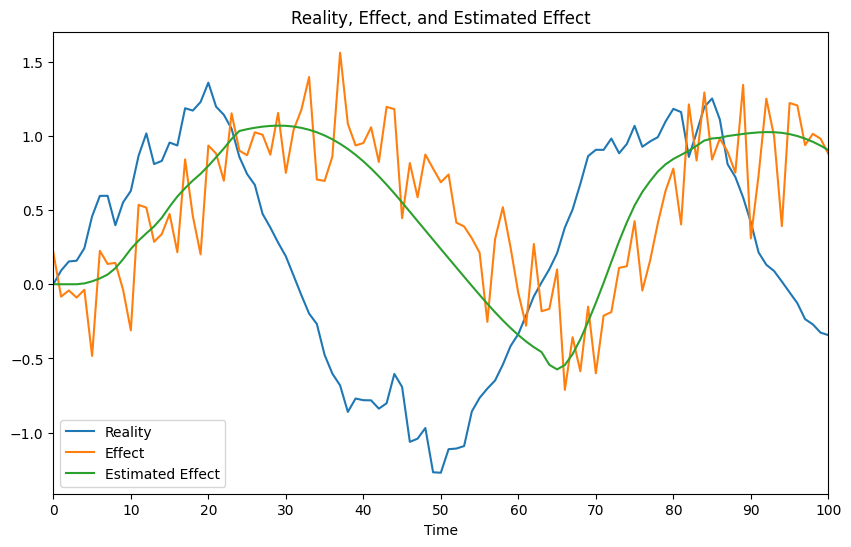

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Adjust figure size for better readability
plt.figure(figsize=(10, 6))

# Plot the data
plt.plot(df['A'], label='Reality')
plt.plot(df['B'], label='Effect')
plt.plot(asy, label='Estimated Effect')

# Add legend, title, and labels
plt.legend()
plt.title('Reality, Effect, and Estimated Effect')
plt.xlabel('Time')

# Set x-axis ticks and limits
plt.xticks(np.arange(0, 101, 10))
plt.xlim(0, 100)

# Display the plot
plt.show()


Symmetric delay estimation

In [18]:
import numpy as np
import pandas as pd
from statsmodels.api import OLS
import statsmodels.api as sm

def uni_delay6(values, d, o):
    df = values.copy()
    o = round(o)  # Ensure 'o' is an integer

    for i in range(0, o+1):
        column_name = f"B_est_{i}"
        df[column_name] = df["A"].astype(float)
    
    for i in range(0, len(values["A"])-1):
        for j in range(1, o + 1):
            prev_column = f'B_est_{j-1}'
            current_column = f'B_est_{j}'
            df.loc[i+1, current_column] = df.loc[i, current_column] + (df.loc[i, prev_column] - df.loc[i, current_column]) / (d/o)

    X = df[f"B_est_{o}"].values.reshape(-1, 1)
    y = df['B'].values

    # Fitting the model using statsmodels
    model = sm.OLS(y, X).fit()

    # Getting the model's predictions
    y_pred = model.predict(X)

    # Calculating the Mean Squared Error manually, since statsmodels doesn't provide it directly
    mse = np.mean((y - y_pred) ** 2)

    # Extracting the model's coefficients
    # Note: In a model without an intercept, there's just one coefficient for the predictor
    coefficients = model.params[0]
    # Mean Absolute Error
    mae = mean_absolute_error(y, y_pred)
    # R-squared
    r_squared = model.rsquared
    # AIC
    aic = model.aic
    # BIC
    bic = model.bic
    # Confidence Intervals for the coefficients
    ci = model.conf_int()

    return mse, coefficients, mae, r_squared, aic, bic, ci

In [19]:
def create_objective_function(values):
    def objective(params):
        delay1, order = map(int, params)  # Ensure parameters are integers
        mse, _, _, _, _, _, _= uni_delay6(values, delay1, order)
        return mse
    return objective


In [20]:
# Assuming 'simulation_dict' contains your datasets
# 'answers' DataFrame is initialized to store the results

# Define bounds for delay1, and order
benchmark_bounds = [(1, 1000), (1, 11)]

# Adjusted loop to use differential_evolution
# Create a customized objective function for the current dataset
custom_objective = create_objective_function(values)

# Perform the optimization using differential_evolution
#result = differential_evolution(custom_objective, benchmark_bounds, strategy='best1bin', maxiter=1000, popsize=15, tol=0.01, mutation=(0.5, 1), recombination=0.7)
result = differential_evolution(custom_objective, benchmark_bounds)

# Extract the optimal parameter values
optimal_delay1, optimal_order = result.x
#optimal_delay1, optimal_delay2, optimal_order = int(optimal_delay1), int(optimal_delay2), int(optimal_order)  # Convert to integers if necessary

# Recalculate mse and k using the optimal parameters
mse, k, mae, r2, aic, bic, ci = uni_delay6(values, optimal_delay1, optimal_order)

print(f"Optimal delay1: {optimal_delay1}")
#print(f"Optimal delay2: {optimal_delay2}")
print(f"Optimal order: {optimal_order}")
print(f"Optimal mse: {mse}")
print(f"Optimal k: {k}")
print(f"Optimal mae: {mae}")
print(f"Optimal r2: {r2}")
print(f"Optimal AIC: {aic}")
print(f"Optimal BIC: {bic}")
print(f"Optimal CI: {ci}")



Optimal delay1: 392.1722593541029
Optimal order: 1.392497571679061
Optimal mse: 0.0797436901692522
Optimal k: 21.08497486791927
Optimal mae: 0.22296628603670127
Optimal r2: 0.8530609913858112
Optimal AIC: 33.20287998855028
Optimal BIC: 35.81800050539154
Optimal CI: [[19.34882572 22.82112402]]


In [21]:
# Assuming 'simulation_dict' contains your datasets
# 'answers' DataFrame is initialized to store the results

# Define bounds for delay1, and order
benchmark_bounds = [(1, 50), (1, 11)]

# Adjusted loop to use differential_evolution
# Create a customized objective function for the current dataset
custom_objective = create_objective_function(values)

# Perform the optimization using differential_evolution
#result = differential_evolution(custom_objective, benchmark_bounds, strategy='best1bin', maxiter=1000, popsize=15, tol=0.01, mutation=(0.5, 1), recombination=0.7)
result = differential_evolution(custom_objective, benchmark_bounds)

# Extract the optimal parameter values
optimal_delay1, optimal_order = result.x
#optimal_delay1, optimal_delay2, optimal_order = int(optimal_delay1), int(optimal_delay2), int(optimal_order)  # Convert to integers if necessary

# Recalculate mse and k using the optimal parameters
mse, k, mae, r2, aic, bic, ci = uni_delay6(values, optimal_delay1, optimal_order)

print(f"Optimal delay1: {optimal_delay1}")
#print(f"Optimal delay2: {optimal_delay2}")
print(f"Optimal order: {optimal_order}")
print(f"Optimal mse: {mse}")
print(f"Optimal k: {k}")
print(f"Optimal mae: {mae}")
print(f"Optimal r2: {r2}")
print(f"Optimal AIC: {aic}")
print(f"Optimal BIC: {bic}")
print(f"Optimal CI: {ci}")



Optimal delay1: 49.74697263056563
Optimal order: 1.1985648716060542
Optimal mse: 0.1466181762625427
Optimal k: 3.3451642991986006
Optimal mae: 0.30446504254175266
Optimal r2: 0.7298353083596651
Optimal AIC: 94.71330901601425
Optimal BIC: 97.32842953285551
Optimal CI: [[2.94137506 3.74895354]]


In [22]:
# values = simulation_dict[i+1]
results = []

# Iterate over the parameter space
for order in range(1, 11):
    for delay1 in range(1, 101):

        (mse, k, mae, r2, aic, bic, ci) = uni_delay6(values, delay1, order)

        print('order:', order, 'delay1:', delay1)
        results.append({'order': order, 'delay1': delay1, 'mse': mse, 'k': k, 'mae': mae, 'r2': r2, 'aic': aic, 'bic': bic, 'ci': ci})


df_results = pd.DataFrame(results)
df_sorted = df_results.sort_values(by='mse', ascending=True)
top_estimation = df_sorted.iloc[0]

order: 1 delay1: 1
order: 1 delay1: 2
order: 1 delay1: 3
order: 1 delay1: 4
order: 1 delay1: 5
order: 1 delay1: 6
order: 1 delay1: 7
order: 1 delay1: 8
order: 1 delay1: 9
order: 1 delay1: 10
order: 1 delay1: 11
order: 1 delay1: 12
order: 1 delay1: 13
order: 1 delay1: 14
order: 1 delay1: 15
order: 1 delay1: 16
order: 1 delay1: 17
order: 1 delay1: 18
order: 1 delay1: 19
order: 1 delay1: 20
order: 1 delay1: 21
order: 1 delay1: 22
order: 1 delay1: 23
order: 1 delay1: 24
order: 1 delay1: 25
order: 1 delay1: 26
order: 1 delay1: 27
order: 1 delay1: 28
order: 1 delay1: 29
order: 1 delay1: 30
order: 1 delay1: 31
order: 1 delay1: 32
order: 1 delay1: 33
order: 1 delay1: 34
order: 1 delay1: 35
order: 1 delay1: 36
order: 1 delay1: 37
order: 1 delay1: 38
order: 1 delay1: 39
order: 1 delay1: 40
order: 1 delay1: 41
order: 1 delay1: 42
order: 1 delay1: 43
order: 1 delay1: 44
order: 1 delay1: 45
order: 1 delay1: 46
order: 1 delay1: 47
order: 1 delay1: 48
order: 1 delay1: 49
order: 1 delay1: 50
order: 1 

In [23]:
top_estimation

order                                             1
delay1                                          100
mse                                         0.09633
k                                          6.235273
mae                                        0.246442
r2                                         0.822499
aic                                       52.287537
bic                                       54.902658
ci        [[5.6605967788098575, 6.809949096609678]]
Name: 99, dtype: object

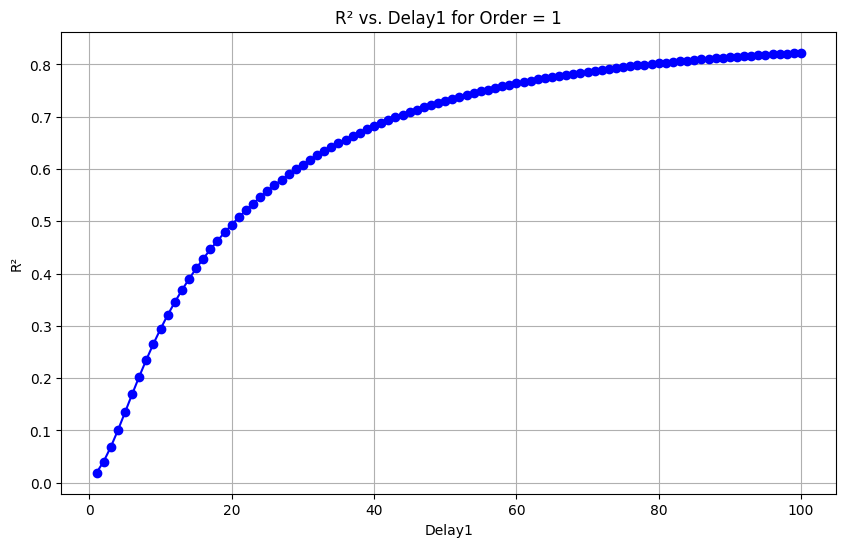

In [24]:
import matplotlib.pyplot as plt

# Filter the DataFrame for order = 1
df_order1 = df_results[df_results['order'] == 1]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(df_order1['delay1'], df_order1['r2'], marker='o', linestyle='-', color='b')
plt.title('R² vs. Delay1 for Order = 1')
plt.xlabel('Delay1')
plt.ylabel('R²')
plt.grid(True)
plt.show()


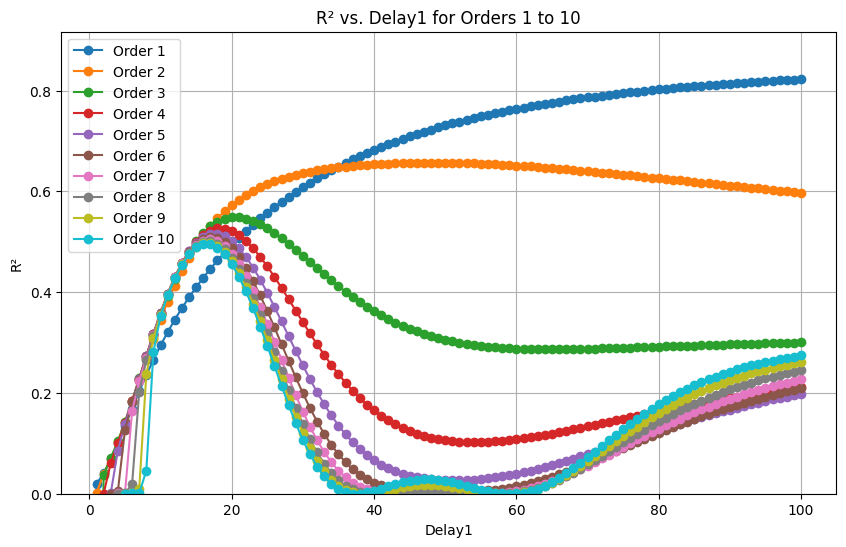

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Loop over the 10 orders
for o in range(1, 11):
    df_temp = df_results[df_results['order'] == o]
    plt.plot(df_temp['delay1'], df_temp['r2'], marker='o', linestyle='-', label=f'Order {o}')

plt.title('R² vs. Delay1 for Orders 1 to 10')
plt.xlabel('Delay1')
plt.ylabel('R²')
plt.grid(True)
plt.legend()
plt.ylim(bottom=0)  # Set the y-axis minimum to 0
plt.show()



In [26]:
uni_delay6(values, 390, 1)

(np.float64(0.07974360686999751),
 np.float64(20.97645831704611),
 0.22297103606310362,
 np.float64(0.8530611448764495),
 np.float64(33.202774485166884),
 np.float64(35.81789500200814),
 array([[19.24924554, 22.70367109]]))

In [60]:
d = 49
o = 1
df = values.copy()

for i in range(0, o+1):
    column_name = f"B_est_{i}"
    df[column_name] = df["A"].astype(float)

for i in range(0, len(values["A"])-1):
    for j in range(1, o + 1):
        prev_column = f'B_est_{j-1}'
        current_column = f'B_est_{j}'
        df.loc[i+1, current_column] = df.loc[i, current_column] + (df.loc[i, prev_column] - df.loc[i, current_column]) / (d/o)

X = df[f"B_est_{o}"].values.reshape(-1, 1)
y = df['B'].values

# Fitting the model using statsmodels
model = sm.OLS(y, X).fit()

# Getting the model's predictions
y_pred = model.predict(X)

# Calculating the Mean Squared Error manually, since statsmodels doesn't provide it directly
mse = np.mean((y - y_pred) ** 2)

# Extracting the model's coefficients
# Note: In a model without an intercept, there's just one coefficient for the predictor
coefficients = model.params[0]
# Mean Absolute Error
mae = mean_absolute_error(y, y_pred)
# R-squared
r_squared = model.rsquared
# AIC
aic = model.aic
# BIC
bic = model.bic
# Confidence Intervals for the coefficients
ci = model.conf_int()

print('mse:', mse, 'k:', coefficients, 'mae:', mae, 'r2:', r_squared, 'aic:', aic, 'bic:', bic, 'ci:', ci)  

mse: 0.1482612687442455 k: 3.2983247110905234 mae: 0.30603875248545764 r2: 0.7268076784643042 aic: 95.83888125236822 bic: 98.45400176920948 ci: [[2.89713172 3.6995177 ]]


In [62]:
single=coefficients*df[f'B_est_{1}']

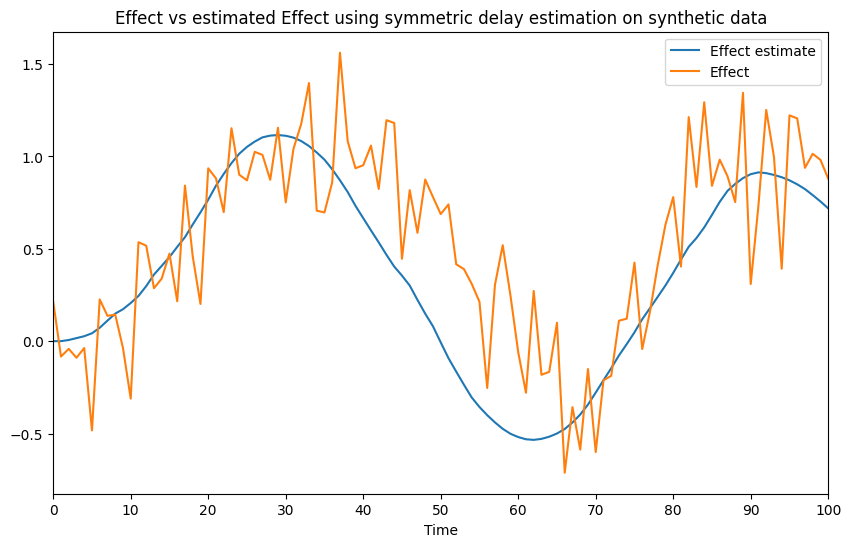

In [67]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Make sure df['date'] is in datetime format
#df['Time'] = pd.to_datetime(df['Time'])

# Adjust figure size for better readability
plt.figure(figsize=(10, 6))

# Plot with 'date' on the x-axis
plt.plot (coefficients*df[f'B_est_{1}'], label='Effect estimate')
plt.plot (df['B'], label='Effect')

# Add legend, title, and labels
plt.legend()
plt.title('Effect vs estimated Effect using symmetric delay estimation on synthetic data')
plt.xlabel('Time')
#plt.ylabel('Stringency')

#x values start from 0 to 100
plt.xticks(np.arange(0, 101, 10))
#X axis starts from 0 and ends at 100
plt.xlim(0, 100) 

# Adjust the frequency and format of x-axis ticks
#plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Adjust interval as needed
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Adjust format as needed

# Rotate and align date labels for better readability
#plt.xticks(rotation=45, ha='right')
#plt.yticks(rotation=45, ha='right')


plt.show()


Fixed delay estimation

In [57]:
def Fixed_delay6(values, i, d):
 
    df = values.copy()
    # Create a list to hold the lagged Series
    lagged_series_list = []

    # Create a new feature for each of the last i observations
    for k in range(1, i+1):
        lagged_series = values['A'].shift(k)
        lagged_series.name = f'A lag{k}'  
        lagged_series_list.append(lagged_series)

    # Concatenate all the Series along axis=1 to create a DataFrame
    lagged_values = pd.concat(lagged_series_list, axis=1)

    # Replace the NaN values with 0 in the new features
    lagged_values = lagged_values.fillna(0)
    
    # Create a weight vector of zeros with the d-th element set to 1
    weights = np.zeros(i)  # Create a zero vector of size i
    if 0 < d <= i:  # Ensure d is within the valid range
        weights[d-1] = 1  # Set the d-th position to 1 (adjust by -1 for 0-based indexing)

    weights = weights.reshape(1, -1)
    weights_transposed = weights.T

    # Compute the dot product of the two matrices
    result = np.dot(lagged_values.values, weights_transposed).reshape(-1) 

    X = result.reshape(-1, 1)
    y = df['B'].values

    # Fitting the model using statsmodels
    model = sm.OLS(y, X).fit()

    # Getting the model's predictions
    y_pred = model.predict(X)

    # Calculating the Mean Squared Error manually, since statsmodels doesn't provide it directly
    mse = np.mean((y - y_pred) ** 2)

    # Extracting the model's coefficients
    # Note: In a model without an intercept, there's just one coefficient for the predictor
    coefficients = model.params[0]
    # Mean Absolute Error
    mae = mean_absolute_error(y, y_pred)
    # R-squared
    r_squared = model.rsquared
    # AIC
    aic = model.aic
    # BIC
    bic = model.bic
    # Confidence Intervals for the coefficients
    ci = model.conf_int()

    return mse, coefficients, mae, r_squared, aic, bic, ci

In [37]:

#values = simulation_dict[i+1]
results = []

# Iterate over the parameter space
for delay1 in range(1, 91):
    # Call your modified function that also returns SSE
    (mse, k, mae, r2, aic, bic, ci) = Fixed_delay6(values, 100, delay1)

    results.append({ 'delay1': delay1, 'mse': mse, 'k': k, 'mae': mae, 'r2': r2, 'aic': aic, 'bic': bic, 'ci': ci})
    print('sim:',i, 'delay1:', delay1)


df_results = pd.DataFrame(results)
df_sorted = df_results.sort_values(by='mse', ascending=True)
top_estimation = df_sorted.iloc[0]




sim: 99 delay1: 1
sim: 99 delay1: 2
sim: 99 delay1: 3
sim: 99 delay1: 4
sim: 99 delay1: 5
sim: 99 delay1: 6
sim: 99 delay1: 7
sim: 99 delay1: 8
sim: 99 delay1: 9
sim: 99 delay1: 10
sim: 99 delay1: 11
sim: 99 delay1: 12
sim: 99 delay1: 13
sim: 99 delay1: 14
sim: 99 delay1: 15
sim: 99 delay1: 16
sim: 99 delay1: 17
sim: 99 delay1: 18
sim: 99 delay1: 19
sim: 99 delay1: 20
sim: 99 delay1: 21
sim: 99 delay1: 22
sim: 99 delay1: 23
sim: 99 delay1: 24
sim: 99 delay1: 25
sim: 99 delay1: 26
sim: 99 delay1: 27
sim: 99 delay1: 28
sim: 99 delay1: 29
sim: 99 delay1: 30
sim: 99 delay1: 31
sim: 99 delay1: 32
sim: 99 delay1: 33
sim: 99 delay1: 34
sim: 99 delay1: 35
sim: 99 delay1: 36
sim: 99 delay1: 37
sim: 99 delay1: 38
sim: 99 delay1: 39
sim: 99 delay1: 40
sim: 99 delay1: 41
sim: 99 delay1: 42
sim: 99 delay1: 43
sim: 99 delay1: 44
sim: 99 delay1: 45
sim: 99 delay1: 46
sim: 99 delay1: 47
sim: 99 delay1: 48
sim: 99 delay1: 49
sim: 99 delay1: 50
sim: 99 delay1: 51
sim: 99 delay1: 52
sim: 99 delay1: 53
si

In [38]:
top_estimation

delay1                                            17
mse                                           0.2793
k                                           0.705565
mae                                         0.456057
r2                                          0.485351
aic                                       159.803156
bic                                       162.418277
ci        [[0.5614197831981123, 0.8497102837640529]]
Name: 16, dtype: object

In [39]:
i =100
d= 17
 
df = values.copy()
# Create a list to hold the lagged Series
lagged_series_list = []

# Create a new feature for each of the last i observations
for k in range(1, i+1):
    lagged_series = values['A'].shift(k)
    lagged_series.name = f'A lag{k}'  
    lagged_series_list.append(lagged_series)

# Concatenate all the Series along axis=1 to create a DataFrame
lagged_values = pd.concat(lagged_series_list, axis=1)

# Replace the NaN values with 0 in the new features
lagged_values = lagged_values.fillna(0)

# Create a weight vector of zeros with the d-th element set to 1
weights = np.zeros(i)  # Create a zero vector of size i
if 0 < d <= i:  # Ensure d is within the valid range
    weights[d-1] = 1  # Set the d-th position to 1 (adjust by -1 for 0-based indexing)

weights = weights.reshape(1, -1)
weights_transposed = weights.T

# Compute the dot product of the two matrices
result = np.dot(lagged_values.values, weights_transposed).reshape(-1) 

X = result.reshape(-1, 1)
y = df['B'].values

# Fitting the model using statsmodels
model = sm.OLS(y, X).fit()

# Getting the model's predictions
y_pred = model.predict(X)

# Calculating the Mean Squared Error manually, since statsmodels doesn't provide it directly
mse = np.mean((y - y_pred) ** 2)

# Extracting the model's coefficients
# Note: In a model without an intercept, there's just one coefficient for the predictor
coefficients = model.params[0]
# Mean Absolute Error
mae = mean_absolute_error(y, y_pred)
# R-squared
r_squared = model.rsquared
# AIC
aic = model.aic
# BIC
bic = model.bic
# Confidence Intervals for the coefficients
ci = model.conf_int()



In [40]:
fixed=coefficients*result

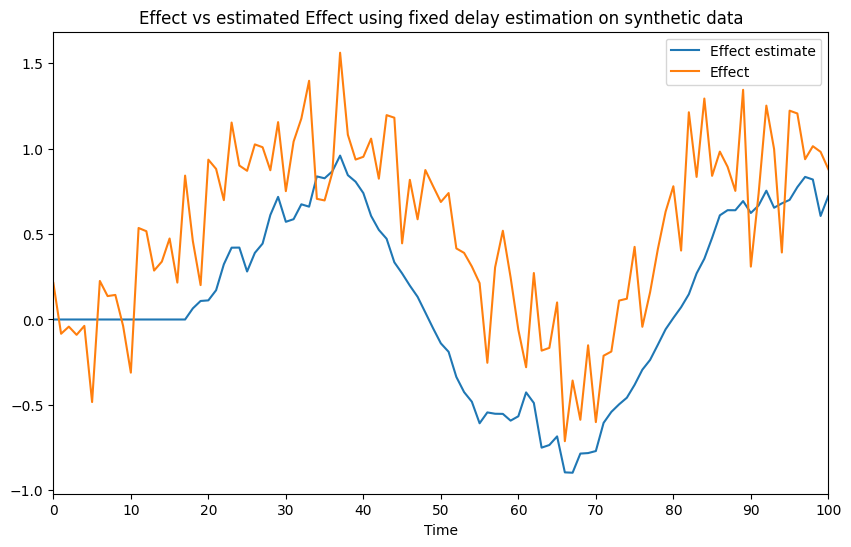

In [41]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Make sure df['date'] is in datetime format
#df['Time'] = pd.to_datetime(df['Time'])

# Adjust figure size for better readability
plt.figure(figsize=(10, 6))

# Plot with 'date' on the x-axis
plt.plot (coefficients*result, label='Effect estimate')
plt.plot (df['B'], label='Effect')

# Add legend, title, and labels
plt.legend()
plt.title('Effect vs estimated Effect using fixed delay estimation on synthetic data')
plt.xlabel('Time')
#plt.ylabel('Stringency')

#x values start from 0 to 100
plt.xticks(np.arange(0, 101, 10))
#X axis starts from 0 and ends at 100
plt.xlim(0, 100) 

# Adjust the frequency and format of x-axis ticks
#plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Adjust interval as needed
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Adjust format as needed

# Rotate and align date labels for better readability
#plt.xticks(rotation=45, ha='right')
#plt.yticks(rotation=45, ha='right')


plt.show()


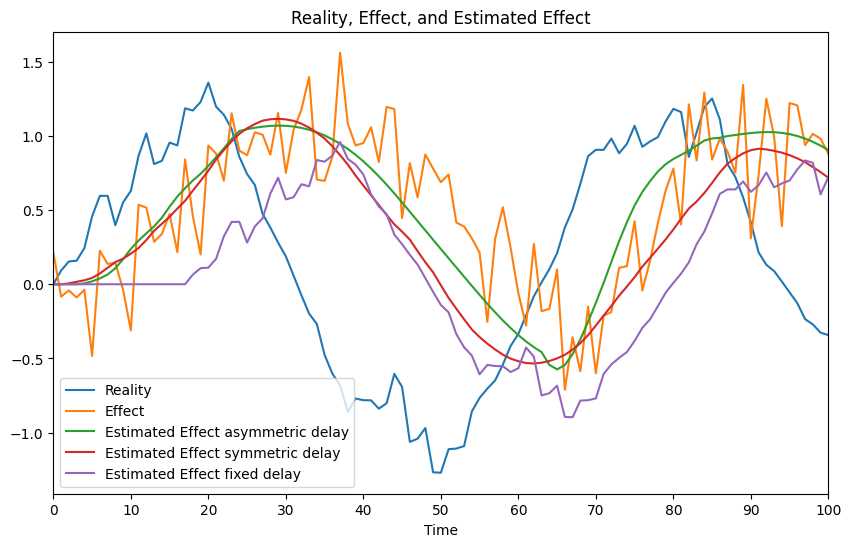

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# Adjust figure size for better readability
plt.figure(figsize=(10, 6))

# Plot the data
plt.plot(df['A'], label='Reality')
plt.plot(df['B'], label='Effect')
plt.plot(asy, label='Estimated Effect asymmetric delay')
plt.plot(single, label='Estimated Effect symmetric delay')
plt.plot(fixed, label='Estimated Effect fixed delay')


# Add legend, title, and labels
plt.legend(loc='lower left')
plt.title('Reality, Effect, and Estimated Effect')
plt.xlabel('Time')

# Set x-axis ticks and limits
plt.xticks(np.arange(0, 101, 10))
plt.xlim(0, 100)

# Display the plot
plt.show()


No delay estimation

In [44]:
df = values
results = []

X = df['A'].values.reshape(-1, 1)
y = df['B'].values

# Fitting the model using statsmodels
model = sm.OLS(y, X).fit()

# Getting the model's predictions
y_pred = model.predict(X)

# Calculating the Mean Squared Error manually, since statsmodels doesn't provide it directly
mse = np.mean((y - y_pred) ** 2)

# Extracting the model's coefficients
# Note: In a model without an intercept, there's just one coefficient for the predictor
coefficients = model.params[0]
# Mean Absolute Error
mae = mean_absolute_error(y, y_pred)
# R-squared
r_squared = model.rsquared
# AIC
aic = model.aic
# BIC
bic = model.bic
# Confidence Intervals for the coefficients
ci = model.conf_int()


results.append({'mse': mse, 'k': coefficients, 'mae': mae, 'r_squared': r_squared, 'aic': aic, 'bic': bic, 'ci': ci})

df_results = pd.DataFrame(results)
df_sorted = df_results.sort_values(by='mse', ascending=True)
top_estimation = df_sorted.iloc[0]





In [45]:
top_estimation

mse                                               0.539037
k                                                  0.07864
mae                                               0.620678
r_squared                                         0.006748
aic                                             226.210506
bic                                             228.825626
ci           [[-0.11064453304881078, 0.26792530626223193]]
Name: 0, dtype: object

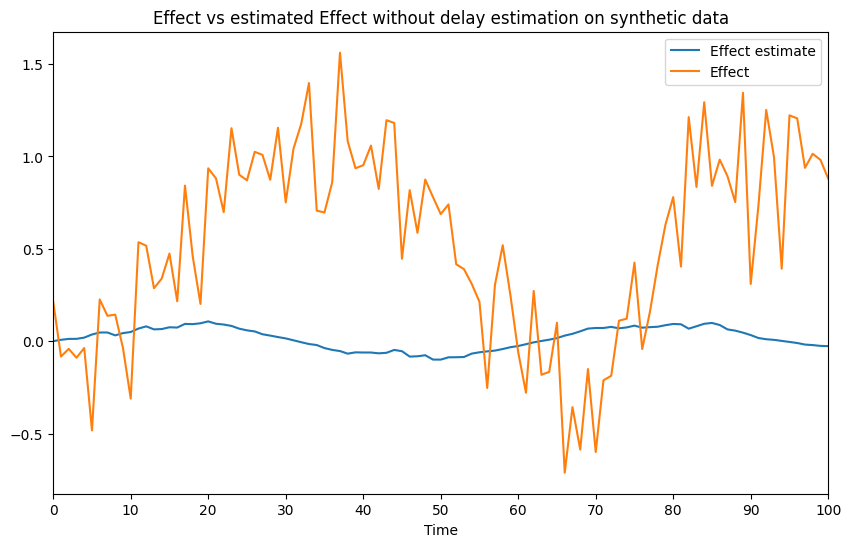

In [46]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Make sure df['date'] is in datetime format
#df['Time'] = pd.to_datetime(df['Time'])

# Adjust figure size for better readability
plt.figure(figsize=(10, 6))

# Plot with 'date' on the x-axis
plt.plot (coefficients*df['A'], label='Effect estimate')
plt.plot (df['B'], label='Effect')

# Add legend, title, and labels
plt.legend()
plt.title('Effect vs estimated Effect without delay estimation on synthetic data')
plt.xlabel('Time')
#plt.ylabel('Stringency')

#x values start from 0 to 100
plt.xticks(np.arange(0, 101, 10))
#X axis starts from 0 and ends at 100
plt.xlim(0, 100) 

# Adjust the frequency and format of x-axis ticks
#plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Adjust interval as needed
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Adjust format as needed

# Rotate and align date labels for better readability
#plt.xticks(rotation=45, ha='right')
#plt.yticks(rotation=45, ha='right')


plt.show()


In [47]:
no_delay = coefficients*df['A']

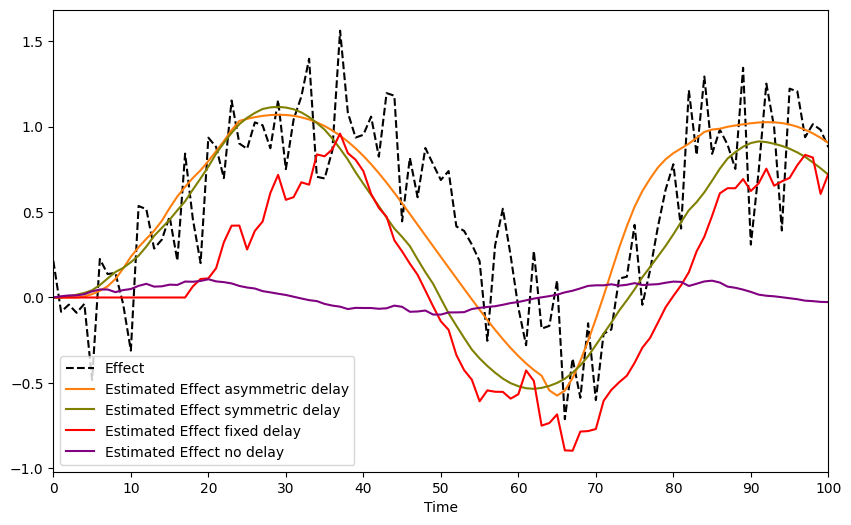

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# Adjust figure size for better readability
plt.figure(figsize=(10, 6))

# Plot the data
#plt.plot(df['A'], label='Reality')
#plt.plot(df['B'], label='Effect')
plt.plot (df['B'], label='Effect', color='black', linestyle='dashed')

plt.plot(asy, label='Estimated Effect asymmetric delay', color='#ff7f0e')
plt.plot(single, label='Estimated Effect symmetric delay', color='olive')
plt.plot(fixed, label='Estimated Effect fixed delay', color='red')
plt.plot(no_delay, label='Estimated Effect no delay', color='purple')


# Add legend, title, and labels
plt.legend(loc='lower left')
#plt.title('Reality, Effect, and Estimated Effect')
plt.xlabel('Time')

# Set x-axis ticks and limits
plt.xticks(np.arange(0, 101, 10))
plt.xlim(0, 100)

# Display the plot
plt.show()


Analysis of the 100 simulation runs by looking at the answers dataframe calcluated in the 100_simulation.ipynb code

In [68]:
#load the answers from the csv file
answers_nonoise = pd.read_csv('../../Data/Synthetic/no_delay_answers.csv', index_col=0)
answers_nonoise

,D1,D2,K,O,best_mse,best_k,best_mae,best_r_squared,best_aic,best_bic,k_lower_limit,k_upper_limit,abs_error_k
Simulation,,,,,,,,,,,,,
1,19.541318,79.692584,-2.273493,1.054768,0.940371,-0.320913,0.824179,0.051564,282.416058,285.031178,-0.593970,-0.047856,1.952581
2,18.519853,78.225166,3.740854,1.722982,2.984795,0.048074,1.578303,0.000384,399.072216,401.687336,-0.438401,0.534549,3.692780
3,34.314858,34.208769,-3.036660,2.676776,0.431092,0.589945,0.574361,0.286117,203.640827,206.255948,0.405066,0.774824,3.626605
4,18.466592,78.802348,-1.972099,3.240107,1.075152,0.089077,0.934287,0.003650,295.944259,298.559379,-0.202893,0.381047,2.061176
5,24.707870,30.612480,-0.546455,3.413189,0.098293,0.094415,0.257110,0.043082,54.325383,56.940504,0.006134,0.182695,0.640870
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,21.598787,5.573183,-0.163758,4.097775,0.068842,-0.037063,0.211719,0.009809,18.354964,20.970085,-0.110943,0.036817,0.126695
97,2.247931,71.415346,-3.685969,2.416931,9.814170,-1.063338,2.874190,0.054100,519.292137,521.907258,-1.945463,-0.181212,2.622632
98,9.206257,47.061376,1.536814,2.714455,0.992257,0.083223,0.871854,0.003453,287.840469,290.455589,-0.197266,0.363712,1.453591


In [69]:
#load the answers from the csv file
answers_fixed = pd.read_csv('../../Data/Synthetic/fixed_answers.csv', index_col=0)
answers_fixed

,D1,D2,K,O,best_delay1,best_mse,best_k,best_mae,best_r2,best_aic,best_bic,k_lower_limit,k_upper_limit,abs_error_delay1,abs_error_k
Simulation,,,,,,,,,,,,,,,
1,19.541318,79.692584,-2.273493,1.054768,73.0,0.527935,-1.773817,0.595586,0.467537,224.108589,226.723710,-2.149378,-1.398256,53.458682,0.499677
2,18.519853,78.225166,3.740854,1.722982,74.0,2.089253,2.481357,1.185585,0.300304,363.043041,365.658161,1.729908,3.232805,55.480147,1.259498
3,34.314858,34.208769,-3.036660,2.676776,26.0,0.129770,-1.121854,0.285109,0.785103,82.384098,84.999219,-1.238299,-1.005408,8.314858,1.914806
4,18.466592,78.802348,-1.972099,3.240107,76.0,0.769220,-1.505399,0.714804,0.287160,262.125329,264.740449,-1.975966,-1.034832,57.533408,0.466700
5,24.707870,30.612480,-0.546455,3.413189,22.0,0.066170,-0.293567,0.206822,0.355806,14.357837,16.972957,-0.371936,-0.215198,2.707870,0.252889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,21.598787,5.573183,-0.163758,4.097775,49.0,0.053341,0.232495,0.182288,0.232768,-7.411085,-4.795965,0.148752,0.316238,27.401213,0.396253
97,2.247931,71.415346,-3.685969,2.416931,71.0,6.085939,-5.371148,2.148690,0.413431,471.029665,473.644785,-6.640437,-4.101858,68.752069,1.685178
98,9.206257,47.061376,1.536814,2.714455,74.0,0.680678,1.470737,0.652481,0.316379,249.774396,252.389516,1.041818,1.899655,64.793743,0.066077


In [70]:
#load the answers from the csv file
answers_uni = pd.read_csv('../../Data/Synthetic/Uni_answers.csv', index_col=0)
answers_uni

,D1,D2,K,O,best_order,best_delay1,best_mse,best_k,best_mae,best_r2,best_aic,best_bic,k_lower_limit,k_upper_limit,abs_error_order,abs_error_delay1,abs_error_k
Simulation,,,,,,,,,,,,,,,,,
1,19.541318,79.692584,-2.273493,1.054768,1.0,100.0,0.308664,-8.792018,0.465050,0.688689,169.899933,172.515053,-9.964780,-7.619255,0.054768,80.458682,6.518524
2,18.519853,78.225166,3.740854,1.722982,2.0,100.0,0.441305,26.325756,0.565361,0.852206,206.005647,208.620768,24.150689,28.500824,0.277018,81.480147,22.584902
3,34.314858,34.208769,-3.036660,2.676776,3.0,34.0,0.058625,-3.074253,0.189696,0.902917,2.130439,4.745560,-3.274250,-2.874256,0.323224,0.314858,0.037593
4,18.466592,78.802348,-1.972099,3.240107,2.0,100.0,0.171767,-15.719874,0.330588,0.840822,110.702578,113.317699,-17.076855,-14.362893,1.240107,81.533408,13.747776
5,24.707870,30.612480,-0.546455,3.413189,5.0,24.0,0.063837,-0.453303,0.196245,0.378525,10.731573,13.346693,-0.568539,-0.338067,1.586811,0.707870,0.093153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,21.598787,5.573183,-0.163758,4.097775,5.0,60.0,0.059592,0.731444,0.192570,0.142851,3.782054,6.397175,0.375974,1.086914,0.902225,38.401213,0.895202
97,2.247931,71.415346,-3.685969,2.416931,2.0,100.0,3.314012,-43.854641,1.531391,0.680592,409.639692,412.254813,-49.815109,-37.894173,0.416931,97.752069,40.168671
98,9.206257,47.061376,1.536814,2.714455,2.0,100.0,0.251277,14.238898,0.427031,0.747637,149.124450,151.739571,12.597629,15.880167,0.714455,90.793743,12.702084


In [71]:
#load the answers from the csv file
answers_asy = pd.read_csv('../../Data/Synthetic/asy_answers.csv', index_col=0)
answers_asy

,D1,D2,K,O,best_order,best_delay1,best_delay2,best_mse,best_k,best_mae,best_r2,best_aic,best_bic,k_lower_limit,k_upper_limit,abs_error_order,abs_error_delay1,abs_error_delay2,abs_error_k
Simulation,,,,,,,,,,,,,,,,,,,
1,19.541318,79.692584,-2.273493,1.054768,1.050765,28.557090,93.779904,0.057480,-2.927126,0.189614,0.942027,0.137738,2.752859,-3.071191,-2.783061,0.004003,9.015772,14.087320,0.653633
2,18.519853,78.225166,3.740854,1.722982,2.130129,21.744342,81.254613,0.057680,4.097818,0.189764,0.980683,0.489117,3.104238,3.983715,4.211921,0.407147,3.224489,3.029447,0.356964
3,34.314858,34.208769,-3.036660,2.676776,4.632301,28.140854,31.281547,0.061541,-2.094060,0.197134,0.898089,7.031940,9.647060,-2.234011,-1.954110,1.955525,6.174004,2.927222,0.942600
4,18.466592,78.802348,-1.972099,3.240107,3.592603,16.047911,76.983505,0.070131,-1.758813,0.210061,0.935009,20.229699,22.844819,-1.850810,-1.666816,0.352496,2.418681,1.818843,0.213286
5,24.707870,30.612480,-0.546455,3.413189,5.394200,18.225544,30.519040,0.054284,-0.447119,0.184726,0.471525,-5.640642,-3.025521,-0.541030,-0.353208,1.981010,6.482327,0.093440,0.099336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,21.598787,5.573183,-0.163758,4.097775,5.081211,17.368423,4.744710,0.058406,-0.163264,0.190353,0.159918,1.750759,4.365880,-0.237504,-0.089024,0.983436,4.230365,0.828472,0.000494
97,2.247931,71.415346,-3.685969,2.416931,2.893944,2.510793,74.734321,0.315452,-3.186511,0.375967,0.969596,172.096992,174.712113,-3.298459,-3.074562,0.477013,0.262863,3.318975,0.499459
98,9.206257,47.061376,1.536814,2.714455,2.156566,11.962481,52.671350,0.056769,1.743886,0.183219,0.942986,-1.119733,1.495387,1.658813,1.828959,0.557888,2.756224,5.609975,0.207072


In [72]:
#add a column in the answers dataframe to indicate the error in K
answers_nonoise['error_K'] = answers_nonoise['K'] - answers_nonoise['best_k']
answers_fixed['error_K'] = answers_fixed['K'] - answers_fixed['best_k']
answers_uni['error_K'] = answers_uni['K'] - answers_uni['best_k']
answers_asy['error_K'] = answers_asy['K'] - answers_asy['best_k']

In [73]:
#calculate the error in order

answers_uni['error_order'] = round(answers_uni['O']) - round(answers_uni['best_order'])
answers_asy['error_order'] = round(answers_asy['O']) - round(answers_asy['best_order'])

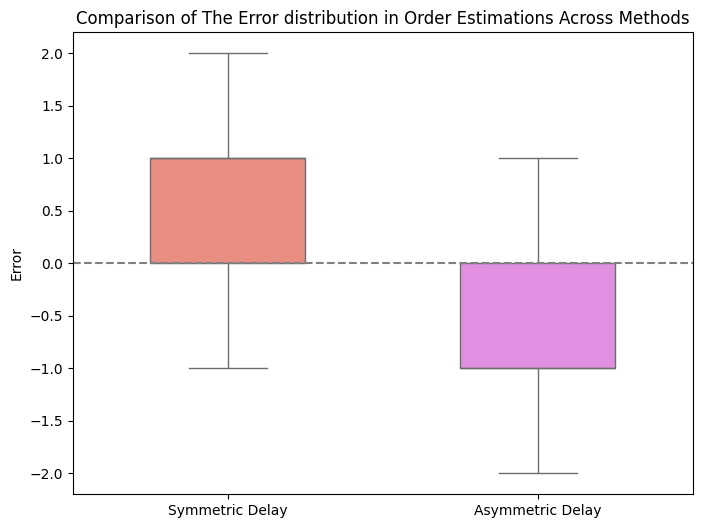

In [74]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming answers_nonoise, answers_fixed, answers_uni, and answers_asy are defined earlier
#answers_nonoise['method'] = 'No Delay'
#answers_fixed['method'] = 'Fixed Delay'
answers_uni['method'] = 'Symmetric Delay'
answers_asy['method'] = 'Asymmetric Delay'

# Combine the data frames
combined_df = pd.concat([answers_uni[['error_order', 'method']],
                         answers_asy[['error_order', 'method']]])

# Define the desired order
order = ['Symmetric Delay', 'Asymmetric Delay']

# Define colors for each method
colors = {
    'Symmetric Delay': 'salmon',
    'Asymmetric Delay': 'violet'
}

plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.boxplot(x='method', y='error_order', hue='method', data=combined_df, order=order,
            width=0.5,  # Increase the width of the box plots to make them denser
            showfliers=False,
            palette=colors,  # Apply custom colors
            legend=False)  # Hide the legend

plt.title('Comparison of The Error distribution in Order Estimations Across Methods')
plt.ylabel('Error')
plt.xlabel('')  # Remove the x-axis label

# Add a dotted line at Y=0
plt.axhline(y=0, color='grey', linestyle='--')

plt.show()


In [75]:
positive_k_nodelay = answers_nonoise[answers_nonoise['K'] > 0]
negative_k_nodelay = answers_nonoise[answers_nonoise['K'] < 0]

positive_k_fixed = answers_fixed[answers_fixed['K'] > 0]
negative_k_fixed = answers_fixed[answers_fixed['K'] < 0]

positive_k_uni = answers_uni[answers_uni['K'] > 0]
negative_k_uni = answers_uni[answers_uni['K'] < 0]

positive_k_asy = answers_asy[answers_asy['K'] > 0]
negative_k_asy = answers_asy[answers_asy['K'] < 0]


/var/folders/5f/kmcr7l_j1t57vby782lbylkr0000gn/T/ipykernel_63761/4162063723.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_k_nodelay.loc[:, 'method'] = 'No Delay'
/var/folders/5f/kmcr7l_j1t57vby782lbylkr0000gn/T/ipykernel_63761/4162063723.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_k_fixed.loc[:, 'method'] = 'Fixed Delay'


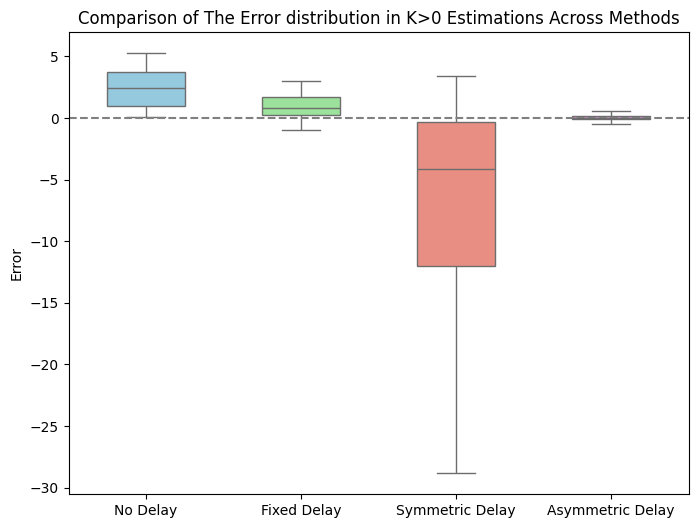

In [76]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming answers_nonoise, answers_fixed, answers_uni, and answers_asy are defined earlier and you've created the positive_k_* DataFrames correctly
positive_k_nodelay.loc[:, 'method'] = 'No Delay'
positive_k_fixed.loc[:, 'method'] = 'Fixed Delay'
positive_k_uni.loc[:, 'method'] = 'Symmetric Delay'
positive_k_asy.loc[:, 'method'] = 'Asymmetric Delay'

# Combine the data frames
combined_df = pd.concat([positive_k_nodelay[['error_K', 'method']], 
                         positive_k_fixed[['error_K', 'method']],
                         positive_k_uni[['error_K', 'method']],
                         positive_k_asy[['error_K', 'method']]])

# Define the desired order
order = ['No Delay', 'Fixed Delay', 'Symmetric Delay', 'Asymmetric Delay']

# Define colors for each method
colors = {
    'No Delay': 'skyblue',
    'Fixed Delay': 'lightgreen',
    'Symmetric Delay': 'salmon',
    'Asymmetric Delay': 'violet'
}

plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.boxplot(x='method', y='error_K', hue='method', data=combined_df, order=order,
            width=0.5,  # Increase the width of the box plots to make them denser
            showfliers=False,
            palette=colors,  # Apply custom colors
            legend=False)  # Hide the legend

plt.title('Comparison of The Error distribution in K>0 Estimations Across Methods')
plt.ylabel('Error')
plt.xlabel('')  # Remove the x-axis label if desired

# Add a dotted line at Y=0
plt.axhline(y=0, color='grey', linestyle='--')

plt.show()


/var/folders/5f/kmcr7l_j1t57vby782lbylkr0000gn/T/ipykernel_63761/4168331281.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_k_nodelay.loc[:, 'method'] = 'No Delay'
/var/folders/5f/kmcr7l_j1t57vby782lbylkr0000gn/T/ipykernel_63761/4168331281.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_k_fixed.loc[:, 'method'] = 'Fixed Delay'


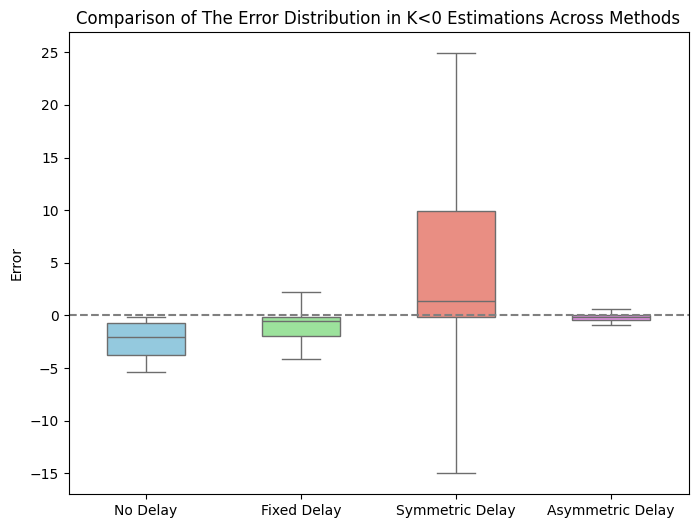

In [77]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming answers_nonoise, answers_fixed, answers_uni, and answers_asy are defined earlier and you've created the positive_k_* DataFrames correctly
negative_k_nodelay.loc[:, 'method'] = 'No Delay'
negative_k_fixed.loc[:, 'method'] = 'Fixed Delay'
negative_k_uni.loc[:, 'method'] = 'Symmetric Delay'
negative_k_asy.loc[:, 'method'] = 'Asymmetric Delay'

# Combine the data frames
combined_df = pd.concat([negative_k_nodelay[['error_K', 'method']], 
                         negative_k_fixed[['error_K', 'method']],
                         negative_k_uni[['error_K', 'method']],
                         negative_k_asy[['error_K', 'method']]])

# Define the desired order
order = ['No Delay', 'Fixed Delay', 'Symmetric Delay', 'Asymmetric Delay']

# Define colors for each method
colors = {
    'No Delay': 'skyblue',
    'Fixed Delay': 'lightgreen',
    'Symmetric Delay': 'salmon',
    'Asymmetric Delay': 'violet'
}

plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.boxplot(x='method', y='error_K', hue='method', data=combined_df, order=order,
            width=0.5,  # Increase the width of the box plots to make them denser
            showfliers=False,
            palette=colors,  # Apply custom colors
            legend=False)  # Hide the legend

plt.title('Comparison of The Error Distribution in K<0 Estimations Across Methods')
plt.ylabel('Error')
plt.xlabel('')  # Remove the x-axis label if desired

# Add a dotted line at Y=0
plt.axhline(y=0, color='grey', linestyle='--')

plt.show()


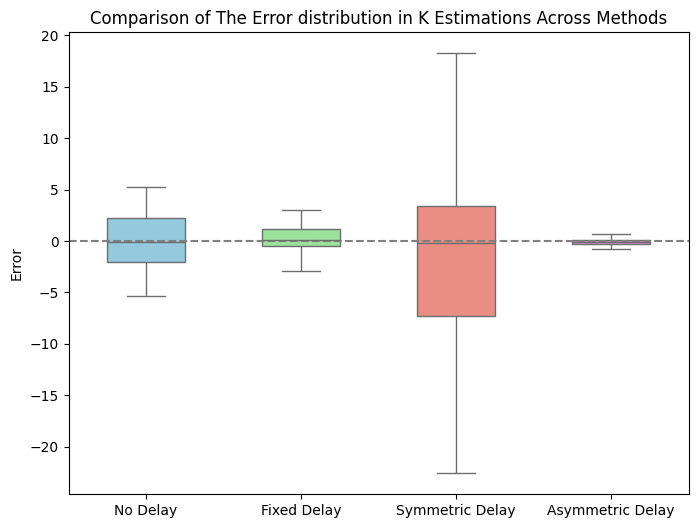

In [78]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming answers_nonoise, answers_fixed, answers_uni, and answers_asy are defined earlier
answers_nonoise['method'] = 'No Delay'
answers_fixed['method'] = 'Fixed Delay'
answers_uni['method'] = 'Symmetric Delay'
answers_asy['method'] = 'Asymmetric Delay'

# Combine the data frames
combined_df = pd.concat([answers_nonoise[['error_K', 'method']], 
                         answers_fixed[['error_K', 'method']],
                         answers_uni[['error_K', 'method']],
                         answers_asy[['error_K', 'method']]])

# Define the desired order
order = ['No Delay', 'Fixed Delay', 'Symmetric Delay', 'Asymmetric Delay']

# Define colors for each method
colors = {
    'No Delay': 'skyblue',
    'Fixed Delay': 'lightgreen',
    'Symmetric Delay': 'salmon',
    'Asymmetric Delay': 'violet'
}

plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.boxplot(x='method', y='error_K', hue='method', data=combined_df, order=order,
            width=0.5,  # Increase the width of the box plots to make them denser
            showfliers=False,
            palette=colors,  # Apply custom colors
            legend=False)  # Hide the legend

plt.title('Comparison of The Error distribution in K Estimations Across Methods')
plt.ylabel('Error')
plt.xlabel('')  # Remove the x-axis label

# Add a dotted line at Y=0
plt.axhline(y=0, color='grey', linestyle='--')

plt.show()


In [79]:
answers_uni['error_delay'] = (answers_uni['best_delay1'] - (answers_uni['D1']+answers_uni['D2'])/2)
answers_fixed['error_delay'] = (answers_fixed['best_delay1'] - (answers_fixed['D1']+answers_fixed['D2'])/2)
answers_asy['error_delay1'] = (answers_asy['best_delay1'] - answers_asy['D1'])
answers_asy['error_delay2'] = (answers_asy['best_delay2'] - answers_asy['D2'])

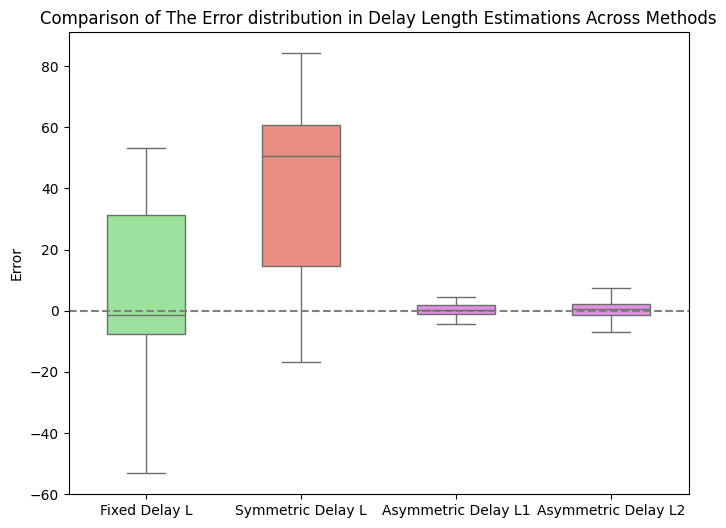

In [80]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming answers_nonoise, answers_fixed, answers_uni, and answers_asy are defined earlier
#answers_nonoise['method'] = 'No Delay'
answers_fixed['method'] = 'Fixed Delay L'
answers_uni['method'] = 'Symmetric Delay L'
answers_asy['method'] = 'Asymmetric Delay L1'
answers_asy['error_delay']= answers_asy['error_delay1']
answers_dup = answers_asy.copy()
answers_dup['method'] = 'Asymmetric Delay L2'
answers_dup['error_delay']= answers_asy['error_delay2']

# Combine the data frames
combined_df = pd.concat([answers_fixed[['error_delay', 'method']],
                         answers_uni[['error_delay', 'method']],
                         answers_asy[['error_delay', 'method']],
                         answers_dup[['error_delay', 'method']]])

# Define the desired order
order = ['Fixed Delay L', 'Symmetric Delay L', 'Asymmetric Delay L1', 'Asymmetric Delay L2']

colors = {
    'Fixed Delay L': 'lightgreen',
    'Symmetric Delay L': 'salmon',
    'Asymmetric Delay L1': 'violet',
    'Asymmetric Delay L2': 'violet'
}
# Use Seaborn to plot
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed

sns.boxplot(x='method', y='error_delay', hue='method', data=combined_df, order=order,
            width=0.5,  # Increase the width of the box plots to make them denser
            showfliers=False,
            palette=colors,  # Apply custom colors
            legend=False)  # Hide the legend

plt.title('Comparison of The Error distribution in Delay Length Estimations Across Methods')
plt.ylabel('Error')
plt.xlabel('')  # Remove the x-axis label

# Add a dotted line at Y=0
plt.axhline(y=0, color='grey', linestyle='--')

plt.show()
